In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-2020-player-performance/IPL 2020 Squads.csv
/kaggle/input/ipl-2020-player-performance/sample_submission.csv
/kaggle/input/ipl-2020-player-performance/Matches IPL 2020.csv
/kaggle/input/ipl-2020-player-performance/Matches IPL 2008-2019.csv
/kaggle/input/ipl-2020-player-performance/Training.csv


In [2]:
import cudf as cd
import cupy as cp

In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import sys
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

In [4]:
from cuml.preprocessing.LabelEncoder import LabelEncoder
from cuml.model_selection import train_test_split
from cuml.metrics.regression import r2_score,mean_squared_log_error,mean_squared_error
from cuml.metrics import confusion_matrix,roc_auc_score,precision_recall_curve
from cuml.metrics.accuracy import accuracy_score
from cuml import ElasticNet
from cuml.ensemble import RandomForestRegressor
import xgboost as xgb

In [5]:
import warnings
warnings.filterwarnings("ignore")

Importing Dataset

In [6]:
train = pd.read_csv("../input/ipl-2020-player-performance/Training.csv",header=0)
cd_train = cd.read_csv("../input/ipl-2020-player-performance/Training.csv",header=0)
cd_train.head()

,Id,Runs,Boundaries,Six,Fifty,Hundred,Duck,Batting_Points,Wickets,4W_Haul,5W_Haul,Maidens,Bowling_Points,Total Points
0,1_Bipul Sharma,0,0,0,0,0,0,0,1,0,0,0,25,25
1,1_DJ Hooda,16,1,1,0,0,0,19,1,0,0,0,25,44
2,1_KM Jadhav,31,5,1,0,0,0,38,0,0,0,0,0,38
3,1_Mandeep Singh,24,5,0,0,0,0,29,0,0,0,0,0,29
4,1_Yuvraj Singh,62,10,3,1,0,0,86,0,0,0,0,0,86


In [7]:
cd_train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 15916 entries, 0 to 15915
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Id              15916 non-null  object
 1   Runs            15916 non-null  int64
 2   Boundaries      15916 non-null  int64
 3   Six             15916 non-null  int64
 4   Fifty           15916 non-null  int64
 5   Hundred         15916 non-null  int64
 6   Duck            15916 non-null  int64
 7   Batting_Points  15916 non-null  int64
 8   Wickets         15916 non-null  int64
 9   4W_Haul         15916 non-null  int64
 10  5W_Haul         15916 non-null  int64
 11  Maidens         15916 non-null  int64
 12  Bowling_Points  15916 non-null  int64
 13  Total Points    15916 non-null  int64
dtypes: int64(13), object(1)
memory usage: 1.8+ MB


In [8]:
train['Match_ID'] = train['Id']
train['Player'] = train['Id']
cd_train['Match_ID'] = cd_train['Id']
cd_train['Player'] = cd_train['Id']
for i in range(len( train)):
    train['Player'][i] =  train['Id'][i].split("_")[-1]
    train['Match_ID'][i] = int( train['Id'][i].split('_')[:1][0])
cd_train['Player']=cd.Series(train['Player'])
cd_train['Match_ID']=cd.Series(train['Match_ID'])

In [9]:
cd_train.head()

,Id,Runs,Boundaries,Six,Fifty,Hundred,Duck,Batting_Points,Wickets,4W_Haul,5W_Haul,Maidens,Bowling_Points,Total Points,Match_ID,Player
0,1_Bipul Sharma,0,0,0,0,0,0,0,1,0,0,0,25,25,1,Bipul Sharma
1,1_DJ Hooda,16,1,1,0,0,0,19,1,0,0,0,25,44,1,DJ Hooda
2,1_KM Jadhav,31,5,1,0,0,0,38,0,0,0,0,0,38,1,KM Jadhav
3,1_Mandeep Singh,24,5,0,0,0,0,29,0,0,0,0,0,29,1,Mandeep Singh
4,1_Yuvraj Singh,62,10,3,1,0,0,86,0,0,0,0,0,86,1,Yuvraj Singh


In [10]:
columns = ['Match_ID','Player','Total Points']
train = train[columns]
cd_train = cd_train[columns]
cd_train.head()

,Match_ID,Player,Total Points
0,1,Bipul Sharma,25
1,1,DJ Hooda,44
2,1,KM Jadhav,38
3,1,Mandeep Singh,29
4,1,Yuvraj Singh,86


In [11]:
submission = pd.read_csv("../input/ipl-2020-player-performance/sample_submission.csv",header=0)
cd_submission = cd.read_csv("../input/ipl-2020-player-performance/sample_submission.csv",header=0)
cd_submission.head()

,Id,Total Points
0,1216492_AS Yadav,0
1,1216492_AT Rayudu,0
2,1216492_DL Chahar,0
3,1216492_F du Plessis,0
4,1216492_HH Pandya,0


In [12]:
submission['Match_ID'] = submission['Id']
submission['Player'] = submission['Id']
cd_submission['Match_ID'] = cd_submission['Id']
cd_submission['Player'] = cd_submission['Id']
for i in range(len( submission)):
    submission['Player'][i] =  submission['Id'][i].split("_")[-1]
    submission['Match_ID'][i] = int( submission['Id'][i].split('_')[:1][0])
    
cd_submission['Player']=cd.Series(submission['Player'])
cd_submission['Match_ID']=cd.Series(submission['Match_ID'])

In [13]:
submission = submission[columns]
cd_submission = cd_submission[columns]
cd_submission.head()

,Match_ID,Player,Total Points
0,1216492,AS Yadav,0
1,1216492,AT Rayudu,0
2,1216492,DL Chahar,0
3,1216492,F du Plessis,0
4,1216492,HH Pandya,0


In [14]:
match8_19 = pd.read_csv("../input/ipl-2020-player-performance/Matches IPL 2008-2019.csv",header=0)
match20 = pd.read_csv("../input/ipl-2020-player-performance/Matches IPL 2020.csv",header=0)
cd_match8_19 = cd.read_csv("../input/ipl-2020-player-performance/Matches IPL 2008-2019.csv",header=0)
cd_match20 = cd.read_csv("../input/ipl-2020-player-performance/Matches IPL 2020.csv",header=0)
match8_19.head()

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,60,2008,Bangalore,18-04-2008,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,61,2008,Chandigarh,19-04-2008,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,62,2008,Delhi,19-04-2008,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,63,2008,Mumbai,20-04-2008,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,64,2008,Kolkata,20-04-2008,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN


In [15]:
teams = match8_19.team1.unique() 
teams2 = match20.team1.unique() 
cd_teams = cd_match8_19.team1.unique() 
cd_teams2 = cd_match20.team1.unique()

print(cd_teams) 
print(cd_teams2)

0             Chennai Super Kings
1                 Deccan Chargers
2                  Delhi Capitals
3                Delhi Daredevils
4                   Gujarat Lions
5                 Kings XI Punjab
6            Kochi Tuskers Kerala
7           Kolkata Knight Riders
8                  Mumbai Indians
9                   Pune Warriors
10               Rajasthan Royals
11         Rising Pune Supergiant
12        Rising Pune Supergiants
13    Royal Challengers Bangalore
14            Sunrisers Hyderabad
Name: team1, dtype: object
0     CSK
1      DC
2     KKR
3    KXIP
4      MI
5     RCB
6      RR
7     SRH
Name: team1, dtype: object


In [16]:
short = { 'Kolkata Knight Riders':'KKR','Chennai Super Kings':'CSK','Rajasthan Royals':'RR',
         'Mumbai Indians':'MI','Deccan Chargers':'SRH','Kings XI Punjab':'KXIP',
         'Royal Challengers Bangalore':'RCB','Delhi Daredevils':'DC',
         'Sunrisers Hyderabad':'SRH','Delhi Capitals':'DC','Rising Pune Supergiants':'RPS',
         'Gujarat Lions':'GL','Rising Pune Supergiant':'RPS','Pune Warriors':'RPS',
         'Kochi Tuskers Kerala':'KTK'}

Matches 2020 have teams in short form like MI, CSK, RCb, thus, we would also change team names to short form in Matches 2008-2019.

In [17]:
match8_19['team1'] = match8_19['team1'].map(short) 
match8_19['team2'] = match8_19['team2'].map(short)
cd_match8_19['team1'] = cd_match8_19['team1'].map(short) 
cd_match8_19['team2'] = cd_match8_19['team2'].map(short)
cd_match8_19.head()

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,60,2008,Bangalore,18-04-2008,KKR,RCB,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,<NA>
1,61,2008,Chandigarh,19-04-2008,CSK,KXIP,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,<NA>
2,62,2008,Delhi,19-04-2008,RR,DC,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,<NA>
3,63,2008,Mumbai,20-04-2008,MI,RCB,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,<NA>
4,64,2008,Kolkata,20-04-2008,SRH,KKR,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,<NA>


In [18]:
match8_19.rename(columns = {'match_id':'Match_ID'}, inplace = True) 
cd_match8_19.rename(columns = {'match_id':'Match_ID'}, inplace = True) 
cd_match8_19.head()

,Match_ID,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,60,2008,Bangalore,18-04-2008,KKR,RCB,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,<NA>
1,61,2008,Chandigarh,19-04-2008,CSK,KXIP,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,<NA>
2,62,2008,Delhi,19-04-2008,RR,DC,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,<NA>
3,63,2008,Mumbai,20-04-2008,MI,RCB,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,<NA>
4,64,2008,Kolkata,20-04-2008,SRH,KKR,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,<NA>


In [19]:
train_m = pd.merge(train[['Match_ID','Player','Total Points']], match8_19[['Match_ID','team1','team2']], on = 'Match_ID', how='inner')
cd_train_m = cd.merge(cd_train[['Match_ID','Player','Total Points']], cd_match8_19[['Match_ID','team1','team2']], on = 'Match_ID', how='inner')
cd_train_m.head()

,Match_ID,Player,Total Points,team1,team2
0,150,AM Nayar,19,MI,DC
1,151,AC Gilchrist,26,SRH,KXIP
2,151,B Lee,42,SRH,KXIP
3,152,SM Harwood,6,RR,CSK
4,150,AM Rahane,14,MI,DC


some of the players are new, so we have to introduce them to our training data else a problem could arise while fitting the data

In [20]:
match20.rename(columns = {'match_id':'Match_ID'}, inplace = True)
cd_match20.rename(columns = {'match_id':'Match_ID'}, inplace = True) 
cd_match20.head()

,Match_ID,city,date,team1,team2,venue,umpire1,umpire2,umpire3
0,1216492,Abu Dhabi,9/19/2020,MI,CSK,"Sheikh Zayed Stadium, Abu Dhabi",Chris Gaffaney,Virender Sharma,Sundaram Ravi
1,1216493,Dubai (DSC),9/20/2020,DC,KXIP,Dubai International Cricket Stadium,Anil Chaudhary,Nitin Menon,Paul Reiffel
2,1216534,Dubai (DSC),9/21/2020,SRH,RCB,Dubai International Cricket Stadium,Anil Dandekar,Nitin Menon,Anil Chaudhary
3,1216496,Sharjah,9/22/2020,RR,CSK,Sharjah Cricket Stadium,Chettithody Shamshuddin,Vineet Kulkarni,KN Ananthapadmanabhan
4,1216508,Abu Dhabi,9/23/2020,KKR,MI,"Sheikh Zayed Stadium, Abu Dhabi",Chris Gaffaney,Sundaram Ravi,Virender Sharma


In [21]:
submit_m = pd.merge(submission[['Match_ID','Player','Total Points']], match20[['Match_ID','team1','team2']], on = 'Match_ID', how='inner')
cd_submit_m = cd.merge(cd_submission[['Match_ID','Player','Total Points']], cd_match20[['Match_ID','team1','team2']], on = 'Match_ID', how='inner')
cd_submit_m.head()

,Match_ID,Player,Total Points,team1,team2
0,1237180,Praveen Dubey,0,DC,SRH
1,1237181,HV Patel,0,DC,MI
2,1237180,SP Goswami,0,DC,SRH
3,1237181,Praveen Dubey,0,DC,MI
4,1237180,Priyam Garg,0,DC,SRH


In [22]:
all_added = pd.concat([train_m,submit_m]) 
cd_all_added = cd.concat([cd_train_m,cd_submit_m]) 
cd_all_added.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 17199 entries, 0 to 1282
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Match_ID      17199 non-null  int64
 1   Player        17199 non-null  object
 2   Total Points  17199 non-null  int64
 3   team1         17199 non-null  object
 4   team2         17199 non-null  object
dtypes: int64(2), object(3)
memory usage: 855.1+ KB


Adding players average scores

In [23]:
Avg_scores = all_added.groupby('Player')['Total Points'].mean().reset_index()
Avg_scores.rename(columns = {'Total Points':'Avg'}, inplace = True) 
cd_Avg_scores = cd_all_added.groupby('Player')['Total Points'].mean().reset_index()
cd_Avg_scores.rename(columns = {'Total Points':'Avg'}, inplace = True) 
cd_Avg_scores.head()

,Player,Avg
0,BB Samantray,18.750000
1,SP Goswami,16.523810
2,M Ashwin,12.161290
3,Priyam Garg,0.000000
4,PP Ojha,24.833333


In [24]:
all_added1 = pd.merge(all_added[['Player','Match_ID','team1','team2']], Avg_scores[['Player','Avg']], on = 'Player', how='inner')
cd_all_added1 = cd.merge(cd_all_added[['Player','Match_ID','team1','team2']], cd_Avg_scores[['Player','Avg']], on = 'Player', how='inner')
print(cd_all_added1.shape)
cd_all_added1.head()

(17199, 5)


,Player,Match_ID,team1,team2,Avg
0,KV Sharma,580,RCB,SRH,26.597015
1,RA Jadeja,130,KXIP,RR,28.355932
2,AD Russell,581,KKR,MI,46.791667
3,KC Sangakkara,130,KXIP,RR,29.926471
4,JC Buttler,581,KKR,MI,32.052632


In [25]:
final_final = pd.merge(all_added[['Match_ID','Player']],all_added1[['Player','Match_ID','team1','team2','Avg']], on = ['Match_ID','Player'], how='inner')
cd_final_final = cd.merge(cd_all_added[['Match_ID','Player']],cd_all_added1[['Player','Match_ID','team1','team2','Avg']], on = ['Match_ID','Player'], how='inner')
print(cd_final_final.shape)
cd_final_final.head()

(17199, 5)


,Match_ID,Player,team1,team2,Avg
0,357,SP Narine,DC,KKR,34.991667
1,545,Yuvraj Singh,KKR,DC,34.434109
2,358,M Kartik,RPS,RR,16.436364
3,545,UT Yadav,KKR,DC,26.308333
4,358,RV Uthappa,RPS,RR,30.373626


In [26]:
X = final_final[['Player','team1','team2','Avg']]
y = train['Total Points']
cd_X = cd_final_final[['Player','team1','team2','Avg']]
cd_y = cd_train['Total Points']
cd_X.head()

,Player,team1,team2,Avg
0,SP Narine,DC,KKR,34.991667
1,Yuvraj Singh,KKR,DC,34.434109
2,M Kartik,RPS,RR,16.436364
3,UT Yadav,KKR,DC,26.308333
4,RV Uthappa,RPS,RR,30.373626


Pre-Processing

In [27]:
label=X.select_dtypes(include='object')
cd_label=cd_X.select_dtypes(include='object')
cd_label

,Player,team1,team2
0,SP Narine,DC,KKR
1,Yuvraj Singh,KKR,DC
2,M Kartik,RPS,RR
3,UT Yadav,KKR,DC
4,RV Uthappa,RPS,RR
...,...,...,...
17194,N Rana,DC,KKR
17195,J Bairstow,KXIP,SRH
17196,JD Unadkat,RCB,RR
17197,J Archer,RCB,RR


In [28]:
labelencoder = LabelEncoder()
cd_label['Player']=labelencoder.fit_transform(cd_label['Player'])
cd_label['team1']=labelencoder.fit_transform(cd_label['team1'])
cd_label['team2']=labelencoder.fit_transform(cd_label['team2'])
cd_label['Avg']=cd_X['Avg']

In [29]:
train_enc = cd_label[:15916]
sub_enc = cd_label[15916:]

In [30]:
train_enc.shape,sub_enc.shape,cd_y.shape

((15916, 4), (1283, 4), (15916,))

In [31]:
# Standard scaling
for col in train_enc.columns:
    a = train_enc[col].mean()
    b = train_enc[col].std()
    train_enc[col]=train_enc[col].applymap(lambda x: ((x-a)/b))
train_enc = train_enc.astype('float32')

for col in sub_enc.columns:
    a = sub_enc[col].mean()
    b = sub_enc[col].std()
    sub_enc[col] = sub_enc[col].applymap(lambda x: ((x-a)/b))
sub_enc = sub_enc.astype('float32')

In [32]:
import scipy.stats as stats

0.21625361645154428


<AxesSubplot:ylabel='Density'>

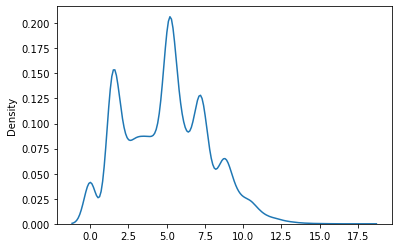

In [33]:
minimum = cd_y.min().copy()
yy = (cd_y.values.get()-minimum)**(1/2)
print(pd.Series(yy).skew())
sns.kdeplot(yy)

<AxesSubplot:ylabel='count'>

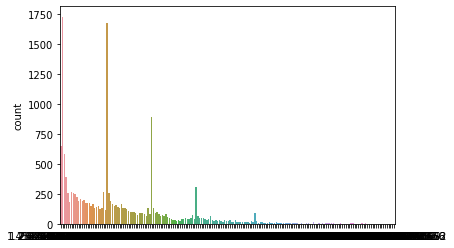

In [34]:
sns.countplot(yy)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_enc, cp.array(yy), test_size=0.2, random_state=25)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12733, 4), (3183, 4), (12733,), (3183,))

In [37]:
X_train

,Player,team1,team2,Avg
12159,0.804730,-0.663455,0.232004,0.268577
6187,0.321396,1.127463,-0.663455,-0.810730
14579,0.551274,0.530490,-1.558914,-0.458775
1899,-1.122711,1.425949,-0.066482,-0.079481
11246,0.179933,-1.558914,-0.066482,-0.824039
...,...,...,...,...
11171,0.156355,-1.558914,-0.663455,0.296078
11704,1.547413,-1.558914,-1.260428,-0.867240
12415,1.671194,-1.558914,-0.663455,0.428879
7967,0.934405,0.828977,-1.260428,-1.382633


In [38]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

Model Fitting

In [39]:
reg = ElasticNet(alpha=0.5)
reg.fit(X_train,y_train)

reg.score(X_test,y_test),r2_score(y_test,reg.predict(X_test)),accuracy_score(y_test,(reg.predict(X_test)))

(-0.00012028217315673828, -0.00012028217315673828, 0.08011309802532196)

In [40]:
y_pred=cp.round(reg.predict(X_test))

Using XG Boost

In [41]:
xgb_reg = xgb.XGBRegressor(max_depth=3, n_estimators=250, learning_rate=0.01,
                            n_jobs=-1,random_state=2519,subsample=0.8)

In [42]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=250,
             n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=2519, reg_alpha=0, reg_lambda=1, ...)

In [43]:
r2_score(y_test,xgb_reg.predict(X_test)),accuracy_score(y_test,xgb_reg.predict(X_test)),(mean_squared_error(y_test,xgb_reg.predict(X_test)))**1/2

(-0.022165656089782715, 0.08011309802532196, array(3.7608202, dtype=float32))

In [44]:
params = {
   
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.9, 
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'learning_rate': 0.01
}

In [45]:
def XGBmodel(X_train,X_test,y_train,y_test,params,val):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    if val:
        model=xgb.train(params=params,
                        dtrain=matrix_train,num_boost_round=5000, 
                        early_stopping_rounds=10,evals=[(matrix_test,'test')])
    else:
        model=xgb.train(params=params,dtrain=matrix_train,num_boost_round=5000)
    return model

model = XGBmodel(X_train,X_test,y_train,y_test,params,True)

[0]	test-rmse:5.20658
[1]	test-rmse:5.16897
[2]	test-rmse:5.13194
[3]	test-rmse:5.09527
[4]	test-rmse:5.05903
[5]	test-rmse:5.02339
[6]	test-rmse:4.98794
[7]	test-rmse:4.95328
[8]	test-rmse:4.91889
[9]	test-rmse:4.88503
[10]	test-rmse:4.85150
[11]	test-rmse:4.81835
[12]	test-rmse:4.78578
[13]	test-rmse:4.75368
[14]	test-rmse:4.72195
[15]	test-rmse:4.69074
[16]	test-rmse:4.65966
[17]	test-rmse:4.62901
[18]	test-rmse:4.59892
[19]	test-rmse:4.56922
[20]	test-rmse:4.53997
[21]	test-rmse:4.51108
[22]	test-rmse:4.48240
[23]	test-rmse:4.45429
[24]	test-rmse:4.42663
[25]	test-rmse:4.39921
[26]	test-rmse:4.37227
[27]	test-rmse:4.34569
[28]	test-rmse:4.31931
[29]	test-rmse:4.29336
[30]	test-rmse:4.26783
[31]	test-rmse:4.24268
[32]	test-rmse:4.21794
[33]	test-rmse:4.19341
[34]	test-rmse:4.16933
[35]	test-rmse:4.14565
[36]	test-rmse:4.12214
[37]	test-rmse:4.09906
[38]	test-rmse:4.07637
[39]	test-rmse:4.05393
[40]	test-rmse:4.03181
[41]	test-rmse:4.00987
[42]	test-rmse:3.98825
[43]	test-rmse:3.9671

In [46]:
prediction = model.predict(xgb.DMatrix(X_test), ntree_limit = model.best_ntree_limit).tolist()

In [47]:
prediction = cp.round(prediction)
prediction

array([5., 5., 5., ..., 5., 5., 5.])

In [48]:
model = XGBmodel(train_enc,X_test,cp.array(yy),y_test,params,False)
prediction = model.predict(xgb.DMatrix(sub_enc), ntree_limit = model.best_ntree_limit).tolist()
prediction = cp.round(cp.array(prediction)**2+minimum)
prediction

array([24., 24., 18., ..., 20., 22., 28.])

In [49]:
prediction = [10 if i < 0 else i for i in prediction]

In [50]:
sub = cd.read_csv("../input/ipl-2020-player-performance/sample_submission.csv",header=0)
submission1 = sub.copy()
submission1.head()

,Id,Total Points
0,1216492_AS Yadav,0
1,1216492_AT Rayudu,0
2,1216492_DL Chahar,0
3,1216492_F du Plessis,0
4,1216492_HH Pandya,0


In [51]:
y_pred = [10 if i<0 else i for i in y_pred]

In [52]:
submission1['Total Points']=prediction

In [53]:
submission1.to_pandas().to_csv("submission.csv", index=False)